Computing gradients.
Computing median gradients.


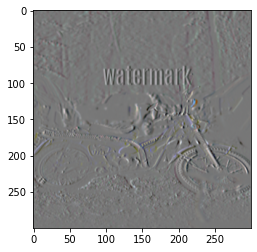

In [1]:
import cv2
from src.estimate_watermark import *
from src.preprocess import *
from src.image_crawler import *
from src.watermark_reconstruct import *

# select one image and put it in folder 'estimate'
# compute its gradient

train_pth = 'random/train/'
test_pth = 'random/test/'
result_pth = 'random/result_test/'

gx, gy, gxlist, gylist = estimate_watermark(train_pth+'estimate')
plt.imshow(PlotImage(gx))
plt.draw()

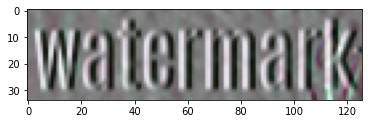

In [2]:
# set start position and end position manually and crop gx & gy
sx=73
ex=107
sy=94
ey=220
lx=ex-sx
ly=ey-sy
cropped_gx = gx[sx:ex,sy:ey,:]
cropped_gy = gy[sx:ex,sy:ey,:]
plt.imshow(PlotImage(cropped_gx))
plt.draw()

In [3]:
# ------------------------------- train ----------------------------------

In [4]:
# number of images in train set
num_images = 10

# s is a list to save start positions of watermarked areas
s = []

for i in range(num_images):
#     print(i)
    im = cv2.imread(train_pth+"watermarked/"+str(i+1)+"_random.png")
    im, s1, l1 = watermark_detector(im, cropped_gx, cropped_gy)
    s.append(s1)

print(s)

[(73, 94), (168, 167), (66, 88), (185, 46), (266, 163), (36, 60), (162, 122), (226, 221), (223, 68), (210, 93)]


In [5]:
# crop images and add it to our matrix
J,file_names,num_J = get_cropped_images2(
    train_pth+'watermarked/', num_images, s, cropped_gx.shape)

# num_J stands for number of valid images, that is, number of images we really use for training
print(num_J)

8


In [6]:
# Compute grads for all images in J
print("Computing gradients.")
gradx = list(map(lambda x: cv2.Sobel(x, cv2.CV_64F, 1, 0, ksize=KERNEL_SIZE), J))
grady = list(map(lambda x: cv2.Sobel(x, cv2.CV_64F, 0, 1, ksize=KERNEL_SIZE), J))

# Compute median of grads
print("Computing median gradients.")
Wm_x = np.median(np.array(gradx), axis=0)
Wm_y = np.median(np.array(grady), axis=0)

# plt.imshow(PlotImage(Wm_x))
# plt.draw()

# estimate_watermark.poisson_reconstruct
W_m = poisson_reconstruct(Wm_x, Wm_y)
Wm = W_m - W_m.min()

Computing gradients.
Computing median gradients.


In [7]:
# get threshold of W_m for alpha matte estimate
alph_est = estimate_normalized_alpha(J, Wm, num_J)
alph = np.stack([alph_est, alph_est, alph_est], axis=2)

Estimating normalized alpha using 8 images.


In [8]:
# Jk = E(Wm) + c · αn · E[Ik]
C, est_Ik = estimate_blend_factor(J, Wm, alph)

0.37540836016291024
0.2911396786704851
0.3050224697967908


------------------------------------
Iteration: 0
Step 1


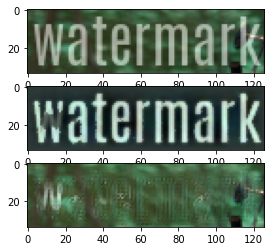

0


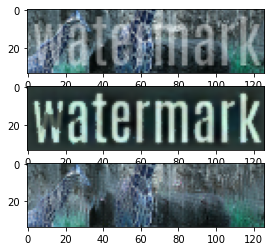

1


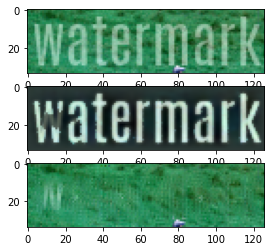

2


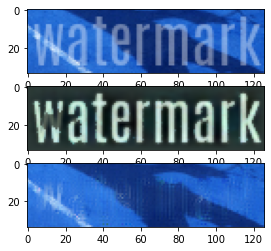

3


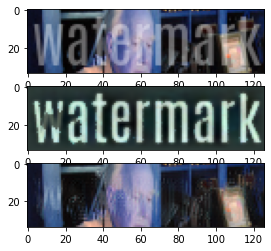

4


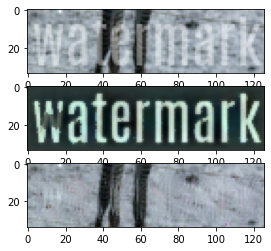

5


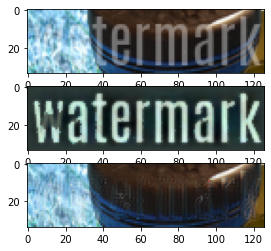

6


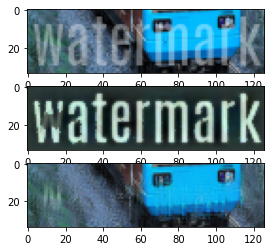

7


F:\SRTPfiles\semi-automatic-watermark-removal\src\estimate_watermark.py:59: RuntimeWarning: invalid value encountered in true_divide
  return (im - np.min(im))/(np.max(im) - np.min(im))


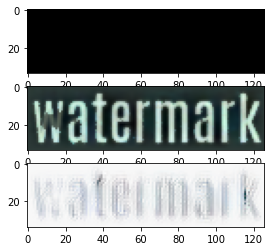

8


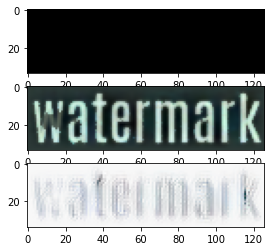

9
Step 2


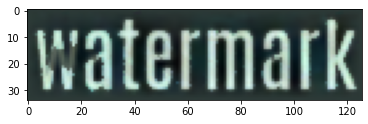

Step 3


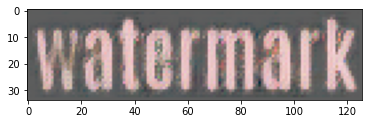

------------------------------------
Iteration: 1
Step 1


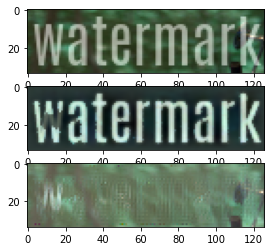

0


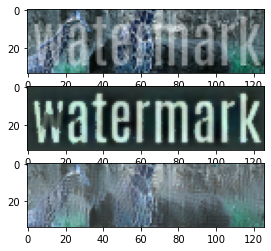

1


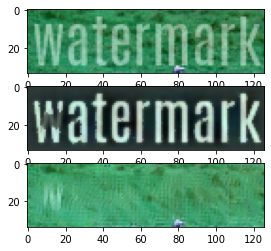

2


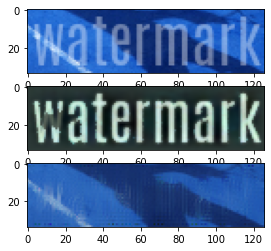

3


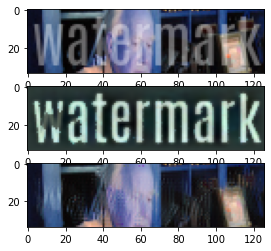

4


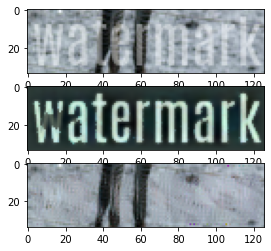

5


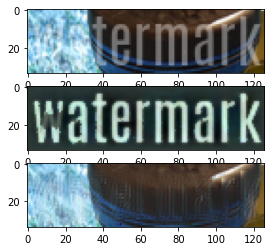

6


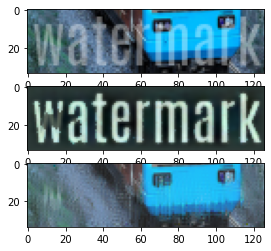

7


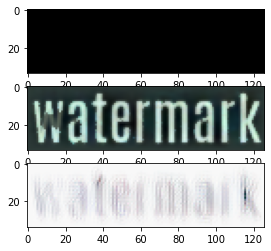

8


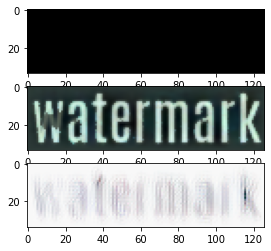

9
Step 2


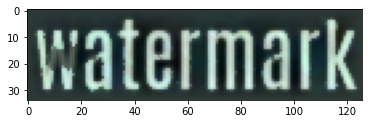

Step 3


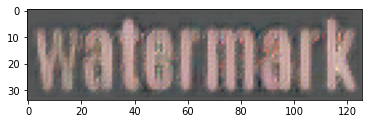

In [9]:
alpha = alph.copy()
for i in range(3):
    alpha[:, :, i] = C[i] * alpha[:, :, i]    # α = c · αn
    
Wm = Wm + alpha * est_Ik      # Est(Wm) = c · αn W − c · αn E[Ik]

W = Wm.copy()
for i in range(3):
    W[:, :, i] /= C[i] 

if num_J>25:
    Jt = J[:25]
else:
    Jt = J

# now we have the values of alpha, Wm, J
# Solve for all images
Wk, Ik, W, alpha1 = solve_images(Jt, W_m, alpha, W)

In [10]:
alpha1[alpha1 < 0] = 0
W[W<0] = 0

# add borders
bsize =2
bsize2 = 4
_shape = ((lx+bsize2),(ly+bsize2),3)

W0 = np.zeros(_shape)
W0[bsize:(lx+bsize), bsize:(ly+bsize), :] = W

alpha2 = np.zeros(_shape)
alpha2[bsize:(lx+bsize), bsize:(ly+bsize), :] = alpha1

cropped_gx1 = np.zeros(_shape)
cropped_gx1[bsize:(lx+bsize), bsize:(ly+bsize), :] = cropped_gx

In [11]:
# ------------------------------- test ----------------------------------

In [12]:
# number of images in test set
test_num=2
s_n=[]

for i in range(test_num):
#     print(i)
    im = cv2.imread(test_pth+"watermarked/"+str(i+1)+"_random.png")
    im, s1, l1 = watermark_detector(im, cropped_gx, cropped_gy)
    s_n.append((s1[0]-bsize,s1[1]-bsize))

J_n,file_names,num_Jn = get_cropped_images2(
    test_pth+'watermarked/', test_num,s_n, cropped_gx1.shape)

Wk, Ik, W2, alpha3 = get_images(J_n, W0, alpha2)

for i in range(test_num):
    cv2.imwrite(test_pth+'patch/'+str(i)+'.png',Ik[i])

get the original images
0
1


In [13]:
# join patch and image
_lx = cropped_gx1.shape[0]
_ly = cropped_gx1.shape[1]
_s=s_n

for i in range(0,test_num):    
    _img=cv2.imread(test_pth+"watermarked/"+ file_names[i])  
    _mark=cv2.imread(test_pth+'patch/'+ str(i)+'.png')
    _img[_s[i][0]:(_s[i][0]+_lx), _s[i][1]:(_s[i][1]+_ly)]=_mark
    cv2.imwrite(result_pth+ file_names[i],_img)
    print("success: "+ str(i))
    

success: 0
success: 1


In [14]:
# save W,alpha,cropped_gx,s to disk
cv2.imwrite(result_pth+'W.png',W)
cv2.imwrite(result_pth+'alpha.png',alpha1)
cv2.imwrite(result_pth+'cropped_gx.png',cropped_gx)
cv2.imwrite(result_pth+'cropped_gy.png',cropped_gy)

f1 = open(result_pth+"s.txt", "w")
f1.write(str(s))
f1.close()